In [63]:
from enum import Enum

import cv2
import pygame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# More than we need, but may as well have ready
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Utility functions

In [61]:
def thresholded_component(img, lower, upper, component_idx):
    '''Take one component / layer / color and return a map of values between upper and lower'''
    component = img[:,:,component_idx]
    _, lower_thresh = cv2.threshold(component, lower, 1, cv2.THRESH_BINARY)
    _, upper_thresh = cv2.threshold(component, upper, 1, cv2.THRESH_BINARY_INV)
    return lower_thresh * upper_thresh

## Load image

In [2]:
cap = cv2.VideoCapture('sample_media/bird flying led sample.mp4')
success, img = cap.read()
fps = cap.get(cv2.CAP_PROP_FPS)
fps
# Get the first two items, reversed
shape = img.shape[1::-1]

In [5]:
# It seems I needed to run this two more times
success, img = cap.read()

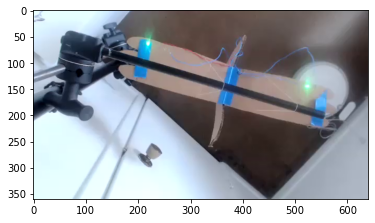

In [6]:
plt.imshow(img[:,:,2::-1])

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)

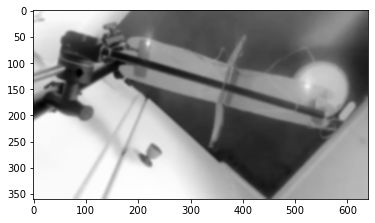

In [8]:
plt.imshow(blurred, cmap='gray')

# Image analysis

First, a quick check that we get strict 0 and maxval values. We can easily work with this using boolean logic.

In [53]:
_, thresh = cv2.threshold(blurred, 220, 1, cv2.THRESH_BINARY)
pd.Series(thresh.flatten()).value_counts()

0    185356
1     45044
dtype: int64

## Grayscale

In [9]:
def show_thresholded(lower=200):
    _, thresh = cv2.threshold(blurred, lower, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh)

In [11]:
interact(show_thresholded, lower=(150, 255))

interactive(children=(IntSlider(value=200, description='lower', max=255, min=150), Output()), _dom_classes=('w…

<function __main__.show_thresholded(lower=200)>

## RGB colorspace

In [12]:
@interact(lower=(150, 255))
def green_thresholded(lower=200):
    # Our image is BGR, i.e., second index (1) is green
    _, thresh = cv2.threshold(img[:,:,1], lower, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh)

interactive(children=(IntSlider(value=200, description='lower', max=255, min=150), Output()), _dom_classes=('w…

In [30]:
@interact(lower=(150, 255))
def red_thresholded(lower=200):
    red = img[:,:,2]
    _, thresh = cv2.threshold(red, lower, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh)
    # plt.imshow(avg_redblue, cmap='gray')

interactive(children=(IntSlider(value=200, description='lower', max=255, min=150), Output()), _dom_classes=('w…

In [31]:
@interact(lower=(150, 255))
def blue_thresholded(lower=200):
    blue = img[:,:,0]
    _, thresh = cv2.threshold(blue, lower, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh)
    # plt.imshow(avg_redblue, cmap='gray')

interactive(children=(IntSlider(value=200, description='lower', max=255, min=150), Output()), _dom_classes=('w…

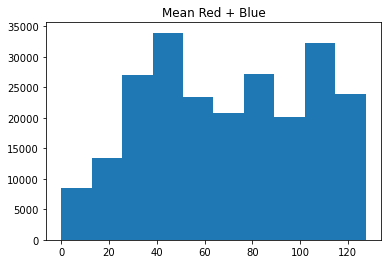

In [27]:
avg_redblue = (img[:,:,0] + img[:,:,2]) / 2
plt.hist(avg_redblue.flatten())
plt.title('Mean Red + Blue')
plt.show()

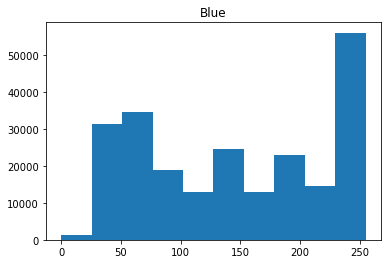

In [28]:
plt.hist(img[:,:,0].flatten())
plt.title('Blue')
plt.show()

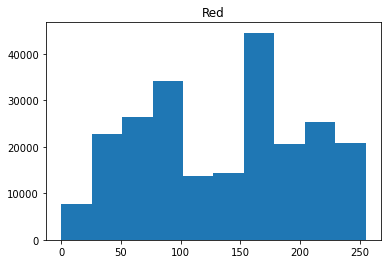

In [29]:
plt.hist(img[:,:,2].flatten())
plt.title('Red')
plt.show()

### Interim summary

The above makes me think that we may need to move into more of a hue-based colorspace. Based on [this dicsussion](https://www.researchgate.net/post/What_would_be_a_good_colour_space_to_deal_with_images_taken_in_varying_lighting_conditions), YCbCr is more robust under variable lighting conditions (which we have for now at least).

## Better colorspaces?

Enums suck for indexing, so we just use constants

In [70]:
class YCrCb(Enum):
    Y = 0
    Cr = 1
    Cb = 2
    
Y = 0
Cr = 1
Cb = 2

In [66]:
ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
blurred_ycc = cv2.GaussianBlur(ycrcb, (11, 11), 0)

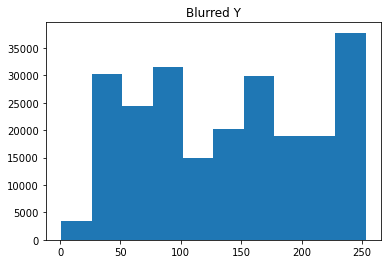

In [71]:
plt.hist(blurred_ycc[:,:,Y].flatten())
plt.title('Blurred Y')
plt.show()

In [72]:
@interact(lower=(150, 255), upper=(200, 255))
def y_thresholded(lower=200, upper=255):
    thresh = thresholded_component(blurred_ycc, lower, upper, Y)
    plt.imshow(thresh)

interactive(children=(IntSlider(value=200, description='lower', max=255, min=150), IntSlider(value=255, descri…

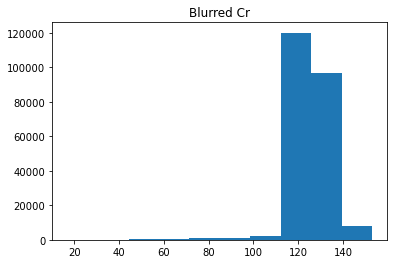

In [73]:
plt.hist(blurred_ycc[:,:,Cr].flatten())
plt.title('Blurred Cr')
plt.show()

In [74]:
@interact(lower=(40, 150), upper=(40, 150))
def Cr_thresholded(lower=120, upper=140):
    cr = blurred_ycc[:,:,Cr]
    _, lower_thresh = cv2.threshold(cr, lower, 1, cv2.THRESH_BINARY)
    _, upper_thresh = cv2.threshold(cr, upper, 1, cv2.THRESH_BINARY_INV)
    thresh = lower_thresh * upper_thresh
    plt.imshow(thresh)

interactive(children=(IntSlider(value=120, description='lower', max=150, min=40), IntSlider(value=140, descrip…

Above we can clearly resolve our pieces of blue tape... our LEDs are also low on the Cr dimension. The upper threshold doesn't buy us anything.

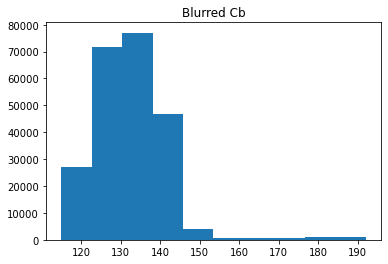

In [41]:
plt.hist(blurred_ycc[:,:,2].flatten())
plt.title('Blurred Cb')
plt.show()

In [57]:
@interact(lower=(110, 200), upper=(110, 200))
def cb_thresholded(lower=130, upper=150):
    cb = blurred_ycc[:,:,2]
    _, lower_thresh = cv2.threshold(cb, lower, 1, cv2.THRESH_BINARY)
    _, upper_thresh = cv2.threshold(cb, upper, 1, cv2.THRESH_BINARY_INV)
    thresh = lower_thresh * upper_thresh
    plt.imshow(thresh)
    # plt.imshow(avg_redblue, cmap='gray')

interactive(children=(IntSlider(value=130, description='lower', max=200, min=110), IntSlider(value=150, descri…

And here we get *just* the tape, NOT the lights. I think we have a solution here.

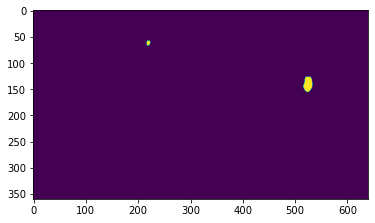

In [76]:
y_thresh = thresholded_component(blurred_ycc, 200, 255, Y)
cr_thresh = thresholded_component(blurred_ycc, 110, 150, Cr)
cb_thresh = thresholded_component(blurred_ycc, 170, 200, Cb)

combined = y_thresh * (1 - cr_thresh)

plt.imshow(combined)

# future directions 

- we might wish to do a background detection step with the leds off. This will of course change with the edges of the birds as well, but my guess is that the subtraction of a static background should still give a reasonable baseline?